![logo](../.././docs/images/Logo_Destination_Earth_Colours.png)

## Polytope Extremes-DT Feature Extraction Timeseries H3 example notebook

This notebook shows how to use earthkit-data and earthkit-plots to pull destination-earth data from LUMI and plot it using earthkit-plots.

In this example we use the H3 python library to convert a hex identifier to a latitude and longitude coordinate and request that point using polytope feature extraction.

Before running the notebook you need to set up your credentials. See the main readme of this repository for different ways to do this or use the following cells to authenticate.

You will need to generate your credentials using the desp-authentication.py script.

This can be run as follows:

In [ ]:
%%capture cap
%run ../desp-authentication.py

This will generate a token that can then be used by earthkit and polytope.

In [ ]:
output_1 = cap.stdout.split('}\n')
access_token = output_1[-1][0:-1]

# Requirements
To run this notebook install the following:
* pip install earthkit-data
* pip install h3
* pip install cf-units         (Optional for unit conversion in maps)

In [1]:
import h3
import earthkit.data
import earthkit.regrid
from polytope.api import Client
from earthkit.plots.interactive import Chart

In [2]:
# Set True if you want to make a live request for the data, or false if you want to use the cached grib file
LIVE_REQUEST = True

In [4]:
cell = h3.latlng_to_cell(51.5072, 0.1276, 2)
latlng = h3.cell_to_latlng('89194e6f357ffff')
LOCATION = latlng

request = {
    "dataset": "extremes-dt",
    "class": "d1",
    "stream": "oper",
    "type": "fc",
    "date": -10,
    "time": "0000",
    "levtype": "sfc",
    "expver": "0001",
    "param": "165/167",
    "feature" : {
        "type" : "timeseries",
        "points": [[LOCATION[0], LOCATION[1]]],
        "time_axis": "step",
        "range": {"start" : 0, "end": 10},
        "axes": ["latitude", "longitude"]
    },
}

In [ ]:
data_file = "data/extremes-dt-earthkit-example-H3.covjson"
if LIVE_REQUEST:
    data = earthkit.data.from_source("polytope", "destination-earth", request, address="polytope.lumi.apps.dte.destination-earth.eu", stream=False)
    data.to_target("file", data_file)
else:
    data = earthkit.data.from_source("file", data_file) 

In [6]:
# Convert data to xarray
ds = data.to_xarray()
ds

<xarray.Dataset> Size: 376B
Dimensions:    (latitude: 1, longitude: 1, levelist: 1, number: 1, datetime: 1,
                t: 11)
Coordinates:
  * latitude   (latitude) float64 8B 51.52
  * longitude  (longitude) float64 8B 0.1638
  * levelist   (levelist) int64 8B 0
  * number     (number) int64 8B 0
  * datetime   (datetime) <U20 80B '2025-07-22T00:00:00Z'
  * t          (t) datetime64[ns] 88B 2025-07-22 ... 2025-07-22T10:00:00
Data variables:
    10u        (latitude, longitude, levelist, number, datetime, t) float64 88B ...
    2t         (latitude, longitude, levelist, number, datetime, t) float64 88B ...
Attributes:
    class:          d1
    dataset:        extremes-dt
    Forecast date:  2025-07-22T00:00:00Z
    expver:         0001
    levtype:        sfc
    stream:         oper
    type:           fc
    number:         0

In [7]:
def location_to_string(location):
    """
    Converts latitude and longitude to a string representation with degrees
    and N/S/E/W.
    """
    (lat, lon) = location
    lat_dir = "N" if lat >= 0 else "S"
    lon_dir = "E" if lon >= 0 else "W"
    return f"{abs(lat):.2f}°{lat_dir}, {abs(lon):.2f}°{lon_dir}"

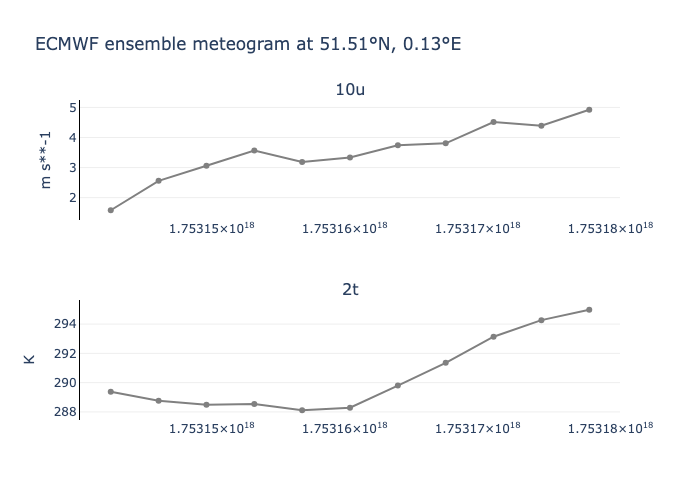

In [8]:
TIME_FREQUENCY = "1h"
QUANTILES = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

chart = Chart()
chart.title(f"ECMWF ensemble meteogram at {location_to_string(LOCATION)}")
#chart.box(ds, time_frequency=TIME_FREQUENCY, quantiles=QUANTILES)
chart.line(ds, line_color='grey', time_frequency=TIME_FREQUENCY)
chart.show("png") # Replace with chart.show() in an interactive session!